In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [22]:
from scipy import integrate, optimize

In [4]:
from datetime import datetime,date,timedelta
import time

In [5]:
import statsmodels.api as sm
import itertools
from pandas.plotting import autocorrelation_plot

In [6]:
from fbprophet import Prophet

In [7]:
from statsmodels.tsa.arima_model import ARIMA

In [80]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scaleale
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV;
from sklearn.linear_model import LinearRegression, BayesianRidge;
from sklearn.tree import DecisionTreeRegressor;
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, mean_absolute_error;
from sklearn.svm import SVR
import xgboost
# import cufflinks
# cufflinks.go_offline(connected=True)
# init_notebook_mode(connected=True)

In [9]:
import plotly
import plotly.express as px
import plotly.io as pio
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
from plotly.offline import iplot, init_notebook_mode

In [10]:
import tensorflow as tf

In [173]:
class CovidAnalysis:
    
    def __init__(self):
        """Constructor for Covid Analysis """
        self.statedf = None
        self._stateupdated = False
        self._processed = False
        self._today = date.today()
        self.scaler = MinMaxScaler(feature_range = (0,1))
        self.labelEncode = LabelEncoder()
        self.tol      = [1e-4, 1e-3, 1e-2]
        self.alpha_1  = [1e-7, 1e-6, 1e-5, 1e-4]
        self.alpha_2  = [1e-7, 1e-6, 1e-5, 1e-4]
        self.lambda_1 = [1e-7, 1e-6, 1e-5, 1e-4]
        self.lambda_2 = [1e-7, 1e-6, 1e-5, 1e-4]
        self.bayesian_grid = {'tol': self.tol,
                         'alpha_1': self.alpha_1,
                         'alpha_2' : self.alpha_2,
                         'lambda_1': self.lambda_1,
                         'lambda_2' : self.lambda_2 }

    def todayDate(self):
        """Display today date """
        print("Today is:",self._today)
            
    def updateState(self,url="https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-states.csv"):
        """ Read the Data from us-States csv and update the state"""
        url = url
        # s=requests.get(url).content
        # self.statedf = pd.read_csv(io.StringIO(s.decode('utf-8')))
        #         
        self.statedf =pd.read_csv("us-states.csv")
        # Change the object date type to  pandas datetime format  
        self.statedf['date'] =  pd.to_datetime(self.statedf['date'], format='%Y-%m-%d')
        self._stateupdated = True
    
    def lastDate(self):
        """Display the latest date in our state data """
        # if file file been read and state has been defined
        if self._stateupdated:
            print("Date of the latest data:",self.statedf.iloc[-1]['date'].date())
        else:
            print("Data has not been updated even once!")

    def head(self,val=5):
        """Display Head of the state data if exists"""
        if self._stateupdated:
            print("First "+str(val)+" rows of the state data")
            print("="*60)
            print(self.statedf.head(val))
    def tail(self,val=5):
        """Display Tail of the state data if exists"""
        if self._stateupdated:
            print("Last  "+str(val)+" rows of the state data")
            print("="*60)
            print(self.statedf.tail(val))
            
    def process(self):
        """ Process the DataFrame and convert it to specific Dictionary 
        which contains the name(key) as state and value as (DataFrame) columns of cases ,deaths and new cases and new deaths """
        # this Remove the warning
        pd.set_option('mode.chained_assignment', None)
        self.statedict= {}
        print("Processing...")
        t1 = time.time()
        if self._stateupdated:
            # list down Unique State names and store it to  list             
            self.statelist = list(self.statedf['state'].unique())
            for s in self.statelist:
                state_df=self.statedf[self.statedf['state']==s]
                # new Cases = Cases - Previous Cases
                state_df['newcases'] = state_df['cases'].diff()
                # New Deaths = Deaths- Previous Deaths
                state_df['newdeaths'] = state_df['deaths'].diff()
                # Store the dictionary value as DataFrame
                self.statedict[s]=state_df
        self._processed = True
        t2 = time.time()
        timeTaken = round(t2-t1,3)
        print("Finished. Took {} seconds".format(timeTaken))

    def topStatewithCriticalSituation(self,feature_col="cases",number=10 ):
        """Plot the Graph Based on Specific feature_column(Cases or Deaths) """ 
        title = 'Top '+ str(number) +' states with highest number of Death Cases'
        if feature_col == "cases":
            title = 'Top ' + str(number) +' states with highest number of Confirmed Cases'
        # Group the state Data Based on the feature column and Select the maximum nlargest values from column  
        df_State = self.statedf.groupby(['state'])[[feature_col]].max().nlargest(number,feature_col)
        fig = px.bar(df_State.sort_values(feature_col)[:20][::-1],x=feature_col,y=df_State.index
                     ,title=title,text=df_State[feature_col], height=900)
        plotly.offline.iplot(fig)


    def plot_state(self,state='New York',last_30_days=False):
        """ Plots statewise data For Cases, Deaths , newCases and newDeaths """
        
        if self._processed==False:
            print("Data not processed yet. Cannot plot statewise.")
            return None
        
        # convert state name to string and compare with statelist for selecting the specific state from data
        s = str(state)
        assert s in self.statelist,"Input does not appear in the list of states. Possibly wrong name/spelling"
        df = self.statedict[s]
        
        # Select cases,deaths,newcases,newDeaths
        dates = df['date']
        cases = df['cases']
        deaths = df['deaths']
        newcases = df['newcases']
        newdeaths = df['newdeaths']

        # Select last 30 days values for cases, deaths,newCases and newDeaths         
        if last_30_days:
            dates = df['date'][-31:-1]
            cases = df['cases'][-31:-1]
            deaths = df['deaths'][-31:-1]
            newcases = df['newcases'][-31:-1]
            newdeaths = df['newdeaths'][-31:-1]
        
        # Plot the Graph for Confirmed Cases 
        title= ""
        if last_30_days:
            title = "Cumulative cases in {}, for last 30 days".format(s)
        else:
            title = "Cumulative cases in {}".format(s)
            
        fig = px.bar(df, x=dates, y=cases)
        layout = go.Layout(title=go.layout.Title(
                text=title,x=0.5),font=dict(size=14),width=800,height=600,
                           xaxis_title = "Date of observation",
                           yaxis_title = "Number of confirmed cases")
        fig.update_layout(layout)
        fig.show()
        
        print()
        
        # Plot the Graph for Death Cases 
        
        if last_30_days:
            title = "Cumulative deaths in {}, for last 30 days".format(s)
        else:
            title = "Cumulative deaths in {}".format(s)
        fig = px.bar(df, x=dates, y=deaths)
        layout = go.Layout(title=go.layout.Title(
                text=title,x=0.5),font=dict(size=14),width=800,height=600,
                           xaxis_title = "Date of observation",
                           yaxis_title = "Number of Death cases")
        fig.update_layout(layout)
        fig.show()
    
        
        print()
        
        # Plot the Graph for New  Cases 
        if last_30_days:
            title = "New cases in {}, for last 30 days".format(s)
        else:
            title = "New cases in {}".format(s)
            
        fig = px.bar(df, x=dates, y=newcases)
        layout = go.Layout(title=go.layout.Title(
                text=title,x=0.5),font=dict(size=14),width=800,height=600,
                           xaxis_title = "Date of observation",
                           yaxis_title = "Number of New cases")
        fig.update_layout(layout)
        fig.show()
       
        print()
    
        # Plot the Graph for New  Death Cases 
        
        if last_30_days:
            title = "New deaths in {}, for last 30 days".format(s)
        else:
            title = "New deaths in {}".format(s)
        fig = px.bar(df, x=dates, y=newdeaths)
        layout = go.Layout(title=go.layout.Title(
                text=title,x=0.5),font=dict(size=14),width=800,height=600,
                           xaxis_title = "Date of observation",
                           yaxis_title = "Number of New Death cases")
        fig.update_layout(layout)
        fig.show()
    
    def plot_multi_state(self, states = ['California','New York','Michigan',],last_30_days=False):
        """Plots multiple states data for comparison in a single graph"""
        if last_30_days:
            colors=[]
            data =[]
            #    
            for state in states:
                color = tuple(np.round(np.random.random(3),2))
                colors.append(color)
                # Select Last 30 days data by state name and show line graph for each state in a list
                data.append(go.Scatter(x = self.statedict[state]['date'][-31:-1],
                                       y = self.statedict[state]['cases'][-31:-1],
                                       mode = "lines",name = state,
                                       marker = dict(color = color),text= state))

            # Layout for the showing multiple graph lines in a single plot
            layout = dict(title = 'Cumulative cases, for last 30 days',xaxis= dict(title= 'Date',ticklen= 5,zeroline= False))
            fig = dict(data = data, layout = layout)
            iplot(fig)
        else:
            colors=[]
            data =[]
            for state in states:
                color = tuple(np.round(np.random.random(3),2))
                colors.append(color)
                # Select  data by state name and show line graph for each state in a list
                data.append(go.Scatter(
                        x = self.statedict[state]['date'],
                        y = self.statedict[state]['cases'],
                        mode = "lines",
                        name = state,
                        marker = dict(color = color),
                        text= state))
            # Layout for the showing multiple graph lines in a single plot
            layout = dict(title = 'Cumulative cases',xaxis= dict(title= 'Date',ticklen= 5,zeroline= False))
            fig = dict(data = data, layout = layout)
            iplot(fig)

            
            
    def rankTopStates(self,N=5,daterank=None):
        """ Ranks the states in a bar chart
        Arguments:
            N: Top N states to be ranked
            date: Date at which the ranking is done.Must be a string in the form '2020-3-27'
        """
        cases = {}
        deaths = {}
        newcases = {}
        newdeaths = {}

        if daterank==None:
            d = self.statedf.iloc[-1]['date'].date()
        else:
            d = datetime.datetime.strptime(daterank,'%Y-%m-%d').date()

        for s in self.statedict:
            df=self.statedict[s]
            for i in range(len(df)):
                if df['date'].iloc[i].date()==d:
                    cases[s]=df.iloc[i]['cases']
                    deaths[s]=df.iloc[i]['deaths']
                    newcases[s]=df.iloc[i]['newcases']
                    newdeaths[s]=df.iloc[i]['newdeaths']

        sorted_cases = sorted(((value, key) for (key,value) in cases.items()),reverse=True)
        sorted_cases = sorted_cases[:N]
        sorted_deaths = sorted(((value, key) for (key,value) in deaths.items()),reverse=True)
        sorted_deaths = sorted_deaths[:N]
        sorted_newcases = sorted(((value, key) for (key,value) in newcases.items()),reverse=True)
        sorted_newcases = sorted_newcases[:N]
        sorted_newdeaths = sorted(((value, key) for (key,value) in newdeaths.items()),reverse=True)
        sorted_newdeaths = sorted_newdeaths[:N]

        fig = make_subplots(rows=2, cols=2,subplot_titles=(
            "Cumulative cases on {}".format(str(d)),"Cumulative deaths on {}".format(str(d)),
            "New cases on {}".format(str(d)), "New deaths on {}".format(str(d))))

        fig.add_trace(go.Bar(x=[val[1] for val in sorted_cases],
                y=[val[0] for val in sorted_cases]),
              row=1, col=1)
        fig.add_trace(go.Bar(x=[val[1] for val in sorted_deaths],
                y=[val[0] for val in sorted_deaths]),
              row=1, col=2)

        fig.add_trace(go.Bar(x=[val[1] for val in sorted_newcases],
                y=[val[0] for val in sorted_newcases]),
              row=2, col=1)

        fig.add_trace(go.Bar(x=[val[1] for val in sorted_newdeaths],
                y=[val[0] for val in sorted_newdeaths]),
              row=2, col=2)

        fig.update_layout(height=600, width=800,
                  title_text="Multiple Subplots with Titles")

        fig.show()
    
    
    
    def PieChart(self,feature_col):
        """ Plot the pie chart for the graph for the states based upon feature column """
        fig = px.pie(self.statedf, values=feature_col, names='state')
        fig.update_traces(textposition='inside')
        fig.update_layout(uniformtext_minsize=12, uniformtext_mode='hide')
        fig.show()
    
    def TreeMap(self,feature_col):
        """ Plot the Tree Map  graph (states) for the states based upon feature column """

        title = "Current Statewise COVID19 " + feature_col +"cases"
        if feature_col == 'cases' :
            title = "Current Statewise COVID19 " + feature_col

        fig = px.treemap(self.statedf, path=['state'], values=feature_col,color=feature_col, hover_data=['state'],
                  color_continuous_scale='matter', title='Current share of Statewise COVID19 '+str(feature_col))
        fig.show()

    def create_time_features(self,df):
        """ Creates time series features from datetime """
        df['date'] = df.index
        df['hour'] = df['date'].dt.hour
        df['dayofweek'] = df['date'].dt.dayofweek
        df['quarter'] = df['date'].dt.quarter
        df['month'] = df['date'].dt.month
        df['year'] = df['date'].dt.year
        df['dayofyear'] = df['date'].dt.dayofyear
        df['dayofmonth'] = df['date'].dt.day
        df['weekofyear'] = df['date'].dt.weekofyear

        X = df[['hour','dayofweek','quarter','month','year',
               'dayofyear','dayofmonth','weekofyear']]
        return X
    
    def AnnModel(self,X,Y):
        """ Using Keras Sequential layer to build a Artifical Neural Network model for prediction"""
        model = tf.keras.Sequential()
        model.add(tf.keras.layers.Dense(units = 128 ,activation = 'relu'))
        model.add(tf.keras.layers.Dense(units = 128 ,activation = 'sigmoid'))
        model.add(tf.keras.layers.Dense(units = 64 ,activation = 'relu'))
        model.add(tf.keras.layers.Dense(units = 32 ,activation = 'sigmoid'))
        model.add(tf.keras.layers.Dense(units = 16 ,activation = 'relu'))
        model.add(tf.keras.layers.Dense(units = 8 ,activation = 'sigmoid'))
        model.add(tf.keras.layers.Dense(units=1))
        # Using Adam Optimizer and Loss function as Mean Squared Error
        model.compile(optimizer =  'adam', loss = 'mean_squared_error',metrics=['accuracy'])
        model.fit(X,Y,batch_size=16,epochs=200)
        return model
    
    def PredictionAnn(self,stateName,forecast_col="cases",date_period=30):
        """Predict Forecast about the state using forecasted column data"""
        
        # Check the statename with  Data in DataFrame
        s = str(stateName)
        assert s in self.statelist,"Input does not appear in the list of states. Possibly wrong name/spelling"
        assert forecast_col in list(self.statedict[s].columns) ,"Forecast Column does not appear to be the column in the states Dataframe. Possibly wrong name/spelling"
        
        df = self.statedict[s].copy(deep=True)

        # string Date to Pandas DateTime Format

        df['date']=pd.to_datetime(df['date'])
        # Set Index to Date
        df.set_index('date', inplace=True)
        
        # Generate date from last index of date from data frame to the period date (in our case 30 dates more)
        dateRange = pd.date_range(start=df.index.max(), periods=date_period)

        #PredictionDate DataFrame contains the date for which we are going to predict the data.
        predictionDates = pd.DataFrame({ 'date': dateRange })
        predictionDates.set_index('date',inplace=True)
        
        # Generate More Features from the date
        self.create_time_features(df)
        self.create_time_features(predictionDates)
        
        
        x_train= df[[ 'month', 'dayofyear', 'dayofmonth' , 'weekofyear']].values
        y_train = df[[forecast_col]]

        x_test = predictionDates[['month', 'dayofyear', 'dayofmonth' , 'weekofyear']]
        
        # Normalizing the Data To make our model generalize better.
        scale = StandardScaler()
        Ytrain_transform = scale.fit_transform(y_train)
        
        # Using the Ann Model for Training
        ann =self.AnnModel(x_train,Ytrain_transform)
        
        # Converting back our prediction to original format.
        prediction = scale.inverse_transform(ann.predict(x_test.values))
        
        plt.figure(figsize= (12, 8))
        plt.subplot(1,1,1)
        
        # Labels for the Graph
        realTitle = "Corona Death Cases"
        title = "Real Number Of Death Cases"
        predictedtitle = "Predicted Number  Of Death Cases (Validation set)"
        if forecast_col == "cases":
            title = "Real Number Of Confirmed Cases"
            predictedtitle = "Predicted Number  Of Confirmed Cases (Validation set)"
            realTitle = "Corona Confirmed Cases"
            
        # predictedtitle = "Predicted Number  Of Confirmed Cases (Validation set)"
        predictionDates["prediction"] = prediction
        # Plot the graph for original cases
        plt.plot(y_train, color = "red", label = title)
        # Plot the graph for prediction cases
        plt.plot(predictionDates["prediction"], color = "blue", label = predictedtitle)
        plt.title(realTitle)
        plt.xlabel("Time")
        plt.ylabel(realTitle +" Count")
        plt.legend()
        plt.grid("both")
        plt.show()
        
        return ann
    
    
    def FeatureLabelEncoder(self,df):
        """"""
        for c in df.columns:
            if df.dtypes[c] == object:
                print("object"+str(c))
                self.labelEncode.fit(df[c].astype(str))
                df[c] = self.labelEncode.transform(df[c].astype(str))
#             print(df)
        return df
    
    def PredictionXGBOOST(self,stateName,forecast_col='cases',period=30):
        """Predict the Forecast using XGBOOST"""
        
        s = str(stateName)
        assert s in self.statelist,"Input does not appear in the list of states. Possibly wrong name/spelling"
        assert forecast_col in list(self.statedict[s].columns) ,"Forecast Column does not appear to be the column in the states Dataframe. Possibly wrong name/spelling"

        df = self.statedict[s].copy(deep=True)

        # string Date to Pandas DateTime Format
        df['date']=pd.to_datetime(df['date'])
        df.set_index('date', inplace=True)  
        
        # Generate date from last index of date from data frame to the period date (in our case 30 dates more)
        daterange = pd.date_range(start=df.index.max(), periods=period)

        #PredictionDate DataFrame contains the date for which we are going to predict the data.
        predictionDates = pd.DataFrame({ 'date': daterange })
        predictionDates.set_index('date',inplace=True)

        # Create Time Features for the Training Data and Prediction Data
        self.create_time_features(df).head()
        self.create_time_features(predictionDates).head()

        # Label Encoding for the object type because we could not use the string/Object type in model training.
        # so we use the label encoding to convert and map the state name to integer.
        train = self.FeatureLabelEncoder(df)
        test = self.FeatureLabelEncoder(predictionDates)
        print("*"*100)
        print(train)
        
#         Important Feature Selection which will be used for the prediction
        x_train= train[[ 'month', 'dayofyear', 'dayofmonth' , 'weekofyear']]
        y1 = train[[forecast_col]]
        
        x_test = test[['month', 'dayofyear', 'dayofmonth' , 'weekofyear']]

        # using The XGBOOST REGRESSION TO PREDICT THE  CASES FOR THE NEXT UPCOMING DAYS
        model = xgboost.XGBRegressor()
        model.fit(x_train,y1)
        prediction1 = model.predict(x_test)
        prediction1 = pd.DataFrame(prediction1)
        
        #
        prediction1.index= pd.RangeIndex(start=len(x_train), stop=len(x_train)+period, step=1)
        
        
        prediction1.columns = [forecast_col+"prediction"]
        
        plt.figure(figsize= (12, 8))
        plt.subplot(1,1,1)
        
        # Labels for the Graph
        realTitle = "Corona Death Cases"
        title = "Real Number Of Death Cases"
        predictedtitle = "Predicted Number  Of Death Cases (Validation set)"
        if forecast_col == "cases":
            title = "Real Number Of Confirmed Cases"
            predictedtitle = "Predicted Number  Of Confirmed Cases (Validation set)"
            realTitle = "Corona Confirmed Cases"
            
        
        plt.plot(train[[forecast_col]].values, color = "blue", label = title)
        plt.plot(prediction1, color = "red", label = predictedtitle)
        # Plot the graph for prediction cases
        plt.title(realTitle)
        plt.xlabel("Time")
        plt.ylabel(realTitle +" Count")
        plt.legend()
        plt.grid("both")
        plt.show()
        
        
        
    
        

    def GrowthFactor(self,state="New York",feature_col="cases"):
        """ Show the Growth Factor of Covid 19 with Cases and Deaths and Growth Factor as 1"""
        s = str(state)
        assert s in self.statelist,"Input does not appear in the list of states. Possibly wrong name/spelling"
        assert feature_col in list(self.statedict[s].columns) ,"Forecast Column does not appear to be the column in the states Dataframe. Possibly wrong name/spelling"
    
        
        df = self.statedict[s]
        date_lst = df["date"]
        
        listLength = len(date_lst) - 1
        confirmed_lst = df["cases"].values;
        death_lst = df["deaths"].values;
        
        
        confGF_lst = []
        deathsGF_lst = []
        df_date_total = df

        data =[]
        # Finding out Growth Factor of confirmed and Deaths cases by diving the new value with old one and append it to list
        for i in range(listLength):
            confirmedGF = confirmed_lst[i+1] / confirmed_lst[i] ;
            confGF_lst.append(confirmedGF)
            deathGF = death_lst[i+1] / death_lst[i] ;
            deathsGF_lst.append(deathGF)
        days_since_lst = [];
        
        for i in range(len(date_lst)):
            days_since_lst.append(i);
        
        df_date_total["Days Since:"] = days_since_lst;
        
        df_date_total = df_date_total[["Days Since:", "cases", "deaths"]];
        
        data.append(go.Scatter(
                        x =days_since_lst,
                        y=confGF_lst,
                        mode = "lines",
                        name="cases Growth",
                        text= "Growth Factor of Confirmed Cases"))
        
        data.append(go.Scatter(
                        x =days_since_lst,
                        y = deathsGF_lst,
                        mode = "lines",
                        name="deathGrowth",
                        text= "Growth Factor of Deaths "))
        x = []
        for i in range((listLength)):
            x.append(1);
        data.append(go.Scatter(
                        x =days_since_lst,
                        y =x,
                        mode = "lines",
                        name="GrowthFactor=1",
                        text= "Growth Factor = 1.0"))
        layout = dict(title = 'Cumulative cases',xaxis= dict(title= 'Date',ticklen= 5,zeroline= False))
        fig = dict(data = data, layout = layout)
        iplot(fig)
            
        
    def RegressionFeatures(self,state="New York",feature_col="cases"):
        """Convert DataFrame Features for Regression so we can used it in Regresssion Algorithms"""
        
        s = str(state)
        assert s in self.statelist,"Input does not appear in the list of states. Possibly wrong name/spelling"
        assert feature_col in list(self.statedict[s].columns) ,"Forecast Column does not appear to be the column in the states Dataframe. Possibly wrong name/spelling"
    
        #Select DateSeries from DataFrame
        df = self.statedict[s]
        date_lst = df["date"]
        
        listLength = len(date_lst) - 1
        
        confirmed_lst = df["cases"].values;
        death_lst = df["deaths"].values;
        
        df_date_total = df
        days_since_lst = [];

                    
        for i in range(len(date_lst)):
            days_since_lst.append(i);
        
        df_date_total["Days Since:"] = days_since_lst;
        
        df_date_total = df_date_total[["Days Since:", "cases", "deaths"]];
        
        X = np.array(df_date_total[feature_col])
        y= np.array(df_date_total["Days Since:"]).reshape(-1,1)
        
        return (X,y)
    
    def LinearRegression(self,X,y):
        """Using Output of Regression Features as input in Linear Regression for
        Training and Testing of Linear Regression"""
        
        # Split the Data From X and Y to train test split dataset
        X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3,shuffle = False)
        # Using sklearn Linear Regression To predict the 
        lin_model = LinearRegression(normalize = False, fit_intercept = False);
        lin_model.fit(y_train, X_train);
        testLinearPredict = lin_model.predict(y_test)
        lin_pred = lin_model.predict(y)
        
        plt.figure(figsize = [15,5]);
        # plotting the actual values for the future days
        plt.plot(y_test,
                 X_test,
                 label = "Actual Confirmed Cases",
                 color = 'crimson')
        # plotting the predicited values for the future days
        plt.plot(y_test,
                 testLinearPredict,
                 label = "Line Regression predicted Confirmed Cases",
                 color = 'gold')
        plt.grid();
        plt.legend();
        plt.xlabel("Day", size = 25)
        plt.ylabel("Count", size = 25)
        plt.xticks(rotation = 90, size = 15);
        plt.show()
        
        # CHecking Mean ABsolute Error for 
        print('MAE:', mean_absolute_error (testLinearPredict, X_test))
        print('MSE:', mean_squared_error  (testLinearPredict, X_test))
        
        plt.figure(figsize=(15, 5))
        plt.plot(y,X,label = 'Actual Future Cases',color = 'crimson')
        plt.plot(y_train,X_train,label = 'Training Cases',color = 'lightgrey')
        plt.plot(y,lin_pred,label = 'Linear Prediction of Future Cases',linestyle = "dashed",color = 'gold')
        plt.xlabel('Days Since', size = 30)
        plt.ylabel('# of Cases', size = 30)
        plt.legend()
        plt.xticks(size=20)
        plt.yticks(size=20)
        plt.show()
        
  
    def PolynomialRegression(self,X,y):
        
        """Using Output of Regression Features as input in Polynomial Regression Regression for
        Training and Testing of Linear Regression"""
        
        # Split the Data From X and Y to train test split dataset
        
        X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.15,shuffle = False)
        
        # Converting our Features To Polynomial Features and then it will
        # be used as input in sklearn Linear Regression algorithm to predict .
        poly = PolynomialFeatures(degree=7)
        poly_y_train = poly.fit_transform(y_train)
        poly_y_test  = poly.fit_transform(y_test)
        poly_y = poly.fit_transform(y)
        # Using Linear Regression with Polynomial Features.
        linear_model = LinearRegression(normalize=True, fit_intercept=False)
        linear_model.fit(poly_y_train, X_train)
        test_linear_pred = linear_model.predict(poly_y_test)
        linear_pred = linear_model.predict(poly_y)
        
        #plot the Actual Confirmed Cases with Predicted
        plt.figure(figsize = [15,5]);
        plt.plot(y_test,
                 X_test,
                 label = "Actual Confirmed Cases",
                 color = 'crimson')
        plt.plot(y_test,
                 test_linear_pred,
                 label = "Polynomial Regression Confirmed Cases",
                 color = 'gold')
        plt.grid();
        plt.legend();
        plt.xlabel("Day", size = 25)
        plt.ylabel("Count", size = 25)
        plt.xticks(rotation = 90, size = 15);
        plt.show()

        print('MAE:', mean_absolute_error(test_linear_pred, X_test))
        print('MSE:',mean_squared_error(test_linear_pred, X_test))
        
        
        plt.figure(figsize=(15, 5))
        plt.plot(y,
                 X,
                 label = 'Actual Future Cases',
                 color = 'crimson')

        plt.plot(y,
                 linear_pred,
                 label = 'Polynomial Regression Prediction of Future Cases',
                 linestyle = "dashed",
                 color = 'gold')

        plt.plot(y_train,
                 X_train,
                 label = 'Training Cases',
                 color = 'lightgrey')

        plt.xlabel('Days Since', size = 30)
        plt.ylabel('# of Cases', size = 30)
        plt.legend()
        plt.xticks(size=20)
        plt.yticks(size=20)
        plt.show()
        
    def RidgeRegression(self,X,y):
        X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.15,shuffle = False)
        # Convert the Train and Test Data and Pass it to Bayesian Ridge Regression 
        bayesian = BayesianRidge(fit_intercept=False, normalize=True)
        bayesian_search = RandomizedSearchCV(bayesian,
                                             self.bayesian_grid,
                                             scoring='neg_mean_squared_error',
                                             cv=3,
                                             return_train_score=True,
                                             n_jobs=-1,
                                             n_iter=40,
                                             verbose=1)

        bayesian_search.fit(y_train, X_train);

        print(bayesian_search.best_params_)
        # Predict using Bayesian Search
        y_test_ridge_pred = bayesian_search.predict(y_test);
        y_ridge_pred = bayesian_search.predict(y);
        plt.figure(figsize = [15,5]);
        # plotting the actual values for the future days
        plt.plot(y_test,
                 X_test,
                 label = "Actual Confirmed Cases",
                 color = 'crimson')
        # plotting the predicited values for the future days
        plt.plot(y_test,
                 y_test_ridge_pred,
                 label = "Ridge predicted Confirmed Cases",
                 color = 'gold')
        plt.grid();
        plt.legend();
        plt.xlabel("Day", size = 25)
        plt.ylabel("Count", size = 25)
        plt.xticks(rotation = 90, size = 15);
        plt.show()

        print('MAE:', mean_absolute_error (y_test_ridge_pred, X_test))
        print('MSE:', mean_squared_error  (y_test_ridge_pred, X_test))

        plt.figure(figsize=(15, 5))
        plt.plot(y,
                 X,
                 label = 'Actual Future Cases',
                 color = 'crimson')
        plt.plot(y,
                 y_ridge_pred,
                 label = 'Ridge Prediction of Future Cases',
                 linestyle = "dashed",
                 color = 'gold')
        plt.plot(y_train,
                 X_train,
                 label = 'Training Cases',
                 color = 'lightgrey')
        #plt.title('# of Coronavirus Cases Over Time', size=30)
        plt.xlabel('Days Since', size = 30)
        plt.ylabel('# of Cases', size = 30)
        plt.legend()
        plt.xticks(size=20)
        plt.yticks(size=20)
        plt.show()
        
        
    def TrainTestSplit(self,state='New York',forecast_col='cases',test_size=0.3):
        """Split the Data into Train Test Data """
        
        if self._processed==False:
            print("Data not processed yet. Cannot plot statewise.")
            return None

        # Check for the state and Forecasted column of its existence
        s = str(state)
        assert s in self.statelist,"Input does not appear in the list of states. Possibly wrong name/spelling"
        assert forecast_col in list(self.statedict[s].columns) ,"Forecast Column does not appear to be the column in the states Dataframe. Possibly wrong name/spelling"

        # select the forecast_cast from the data.
        df = self.statedict[s]
        forecastedColumn = df[forecast_col].astype(int)
        # Using the 75-25% split to convert data into train and test form.
        train_data_size = int(len(df) * 0.75)
        test_data_size = len(df) - train_data_size
        
        dates = df['date']
        # Split the Data in two parts  train and Test 
        forecastedColumn_train_cases = forecastedColumn.iloc[0:train_data_size]
        forecastedColumn_val_cases = forecastedColumn.iloc[train_data_size : len(forecastedColumn)]

        return (forecastedColumn_train_cases,forecastedColumn_val_cases)

    def transformData(self,train): 
        """ Transform the Train data to scaled and normalize features for the better prediction"""
        train_scaled = self.scaler.fit_transform(train)
        x_train = [] 
        y_train = []
        time_step = 1
        
        for i in range(time_step, train_scaled.shape[0]):

            # Using the scaled features and taking the one index at a time for
            # train and using the next date data to predict the cases   
            x_train.append(train_scaled[i-time_step : i , 0])
            y_train.append(train_scaled[i, 0])

        x_train, y_train = np.array(x_train), np.array(y_train)
        # Changing the shape of train data
        print(f"X_train ----{x_train}")
        x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1 ))
        print(f"X_train ---- reshape{x_train}")
        
        y_train = np.reshape(y_train, (y_train.shape[0], 1 ))

        return x_train, y_train 
    
    def PredictionwithLSTM(self,state="New York",forecast_col='cases'):
        """Using LSTM Model To Predict Forecasted Columns"""
        # Declaring EPOCH and BATCH size for Model
        EPOCHS = 100
        BATCH_SIZE = 32
#       Split the data to train and validation data
        train_data,val_data = self.TrainTestSplit(state=state,forecast_col=forecast_col)
#         Transform the Data with Transforming 
        x_train, y_train = self.transformData(train_data.values.reshape(-1,1))
        x_val, y_val = self.transformData(val_data.values.reshape(-1,1))
        # use modelLSTM function to declare model and this model is used for training.
        model=self.modelLSTM(x_train)
        with tf.device("/device:CPU:0"):
            history = model.fit(x_train, y_train,epochs = EPOCHS, verbose = 1,batch_size = BATCH_SIZE, validation_data = (x_val, y_val))
        
        # Predicting the using the Transform Values and Converting the predicted values back to normal form. 
        predicted_cases = model.predict(x_val)
        predicted_cases = self.scaler.inverse_transform(predicted_cases)
        real_cases = self.scaler.inverse_transform(y_val)

        plt.figure(figsize= (12, 8))
        plt.subplot(1,1,1)
        title = "Real Number Of Confirmed Cases"
        predictedtitle = "Predicted Number  Of Confirmed Cases (Validation set)"
        realTitle = "Corona Confirmed Cases"
        if forecast_col == "deaths":
            title = "Real Number of Fatalities Cases"
            predictedtitle = "Predicted Number  Of Fatalities Cases (Validation set)"
            realTitle = "Corona Fatal Cases"
        
        # Plot the graph for real cases vs predicted cases
        plt.plot(real_cases, color = "red", label = title)
        plt.plot(predicted_cases, color = "blue", label = predictedtitle)
        plt.title(realTitle)
        plt.xlabel("Days")
        plt.ylabel("Case Count")
        plt.legend()
        plt.grid("both")
        plt.show()
        
    
    def modelLSTM(self,x_train):
        """This model is used for the Forecasting with the help of LSTM """
        model = tf.keras.Sequential()
        model.add(tf.keras.layers.LSTM(units = 50, return_sequences = True, input_shape = (x_train.shape[1], 1)))
        model.add(tf.keras.layers.Dropout(0.2))
        model.add(tf.keras.layers.LSTM(units = 50, return_sequences = True))
        model.add(tf.keras.layers.Dropout(0.2))
        model.add(tf.keras.layers.LSTM(units = 50, return_sequences = True))
        model.add(tf.keras.layers.Dropout(0.2))
        model.add(tf.keras.layers.LSTM(units = 30, return_sequences = True))
        model.add(tf.keras.layers.Dropout(0.3))
        model.add(tf.keras.layers.LSTM(units = 50, return_sequences = False))
        model.add(tf.keras.layers.Dropout(0.2))
        model.add(tf.keras.layers.Dense(units = 1))
        model.compile(tf.keras.optimizers.Adam(lr = 0.001), loss = "mean_squared_error")
        model.summary()
        return model
     
    def ProphetPrediction(self,stateName,forecast_col='cases',forecast_days=30):
        """using FaceBook Prophet Time Series to Predict the forecast   """
        # Compare stateName with StateList and compare forecase_col with columns 
        s = str(stateName)
        assert s in self.statelist,"Input does not appear in the list of states. Possibly wrong name/spelling"
        assert forecast_col in list(self.statedict[s].columns) ,"Forecast Column does not appear to be the column in the states Dataframe. Possibly wrong name/spelling"
        
        #Select Specific Statename Data
        df = self.statedict[s]
        # Drop new Cases and new Deaths
        df.dropna(subset = ["newcases","newdeaths"], inplace=True)
        print(type(df))
        
        #Select the date and forecast_column(column to be forecasted)
        df_data = df[["date",forecast_col]]
        # Change the columns name from date => ds and forecast_col => y
        # FbProphet demands the dataframe to be in [ds,y] format
        df_data.rename(columns={'date': 'date',forecast_col:'y'}, inplace=True)
        df_data.columns = ['ds', 'y']
        df_data.tail()
        
        #‘interval_width=0.95’, this sets the uncertainty interval to produce a confidence interval around the forecast
        model = Prophet(interval_width=0.95)
        #Fit the Model
        model.fit(df_data)
        #Create prediction Data for the next period
        model_Prediction =  model.make_future_dataframe(periods=forecast_days)
        model_Prediction.tail()
        # Predicting the future with date, and upper and lower limit of y value
        # modelForecast =  model.predict(model_Prediction)
        modelForecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

        yhat = go.Scatter(x = modelForecast['ds'],
                y = modelForecast['yhat'],mode = 'lines',
                marker = {'color': '#3bbed7'},
                line = {'width': 3},name = 'Forecast')
        
        # Plot the graph for lower bound of prediction 
        yhat_lower = go.Scatter(x = modelForecast['ds'],y = modelForecast['yhat_lower'],
          marker = {'color': 'rgba(0,0,0,0)'},
          showlegend = False,hoverinfo = 'none')

        # Plot the graph for upper bound of prediction 
        yhat_upper = go.Scatter(x = modelForecast['ds'],
          y = modelForecast['yhat_upper'],fill='tonexty',
          fillcolor = 'rgba(231, 234, 241,.75)',name = 'Confidence',
          hoverinfo = 'none',mode = 'none')

        # Plot the graph for actual data with respect to date
        actual = go.Scatter(x = df_data['ds'],
          y = df_data["y"],mode = 'markers',
          marker = {
            'color': '#fffaef',
            'size': 4,
            'line': {
              'color': '#000000',
              'width': .75
            }
          },
          name = 'Actual'
        )

        # define a layout for the graph plotting
        layout = go.Layout(yaxis = {'tickformat': format("y"),
        'hoverformat': format("y")},hovermode = 'x',xaxis = {'title': "x"},
            margin = {'t': 20,'b': 50, 'l': 60,'r': 10},
          legend = {'bgcolor': 'rgba(0,0,0,0)'})
        # Adding all graph in data and plot it. 
        data = [actual,yhat_lower, yhat_upper, yhat]
        fig = dict(data = data, layout = layout)
        plotly.offline.iplot(fig)
        
        
    
    def ARIMAPrediction(self,stateName,forecast_col='cases',start_date='2020-10-10'):
        """Using ARIMA MODEL TO PREDICT COVID CASES 
        ARIMA model can be created using the statsmodels library
        """
        #  
        s = str(stateName)
        assert s in self.statelist,"Input does not appear in the list of states. Possibly wrong name/spelling"
        assert forecast_col in list(self.statedict[s].columns) ,"Forecast Column does not appear to be the column in the states Dataframe. Possibly wrong name/spelling"

        # string date to Pandas Date time 
        df = self.statedict[s].copy(deep=True)
        df['date']=pd.to_datetime(df['date'])
        df.set_index('date', inplace=True)    
        print(max(df.index))
        
        #timeSeries
        timeSeries =df[forecast_col]
        # Arima Mode For Checking whether data is seasonal or not.
        decomposition = sm.tsa.seasonal_decompose(timeSeries, model='additive')
        fig = decomposition.plot()
        plt.show()
        
        #     p: Trend autoregression order.
        #     d: Trend difference order.
        #     q: Trend moving average order.
        p = d = q = range(0, 2)

        seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
        #Using the default SARIMAX to predict
        mod = sm.tsa.statespace.SARIMAX(timeSeries,order=(1, 1, 1),seasonal_order=(0, 1, 1, 12),
                                        enforce_stationarity=False,enforce_invertibility=False,freq="D")
        results = mod.fit()
        results.plot_diagnostics(figsize=(16, 8))
        plt.show()
        title = "Real Number Of Confirmed Cases"
        predictedtitle = "Predicted Number  Of Confirmed Cases (Validation set)"
        realTitle = "Corona Confirmed Cases"
        if forecast_col == "deaths":
            title = "Real Number of Fatalities Cases"
            predictedtitle = "Predicted Number  Of Fatalities Cases (Validation set)"
            realTitle = "Corona Fatal Cases"
    
        pred = results.get_prediction(start=pd.to_datetime(start_date), dynamic=False)
        pred_ci = pred.conf_int()
        data =[]
        data.append(go.Scatter(x = timeSeries.index,y = timeSeries.values,
                    mode = "lines",name = title,
                    marker = dict(color = (0,0,255)),text= stateName))
        # Plot the Graph 
        data.append(go.Scatter(x = pred_ci.index,y = pred.predicted_mean,
                    mode = "lines",name = predictedtitle ,
                    marker = dict(color = (0,0,255)),text= predictedtitle ))
        
#       # Layout for the showing multiple graph lines in a single plot
        layout = dict(title = realTitle,xaxis= dict(title= 'Date',ticklen= 5,zeroline= False))
        fig = dict(data = data, layout = layout)
        iplot(fig)



# Implementation

In [188]:
usState= CovidAnalysis()
usState.todayDate()
usState.updateState()
# usState.lastDate()
# usState.head(5)
# usState.tail(5)
usState.process()

Today is: 2020-11-22
Processing...
Finished. Took 0.206 seconds


## Using LSTM

In [190]:
# usState.PredictionwithLSTM(state="New York")

## USING REGRESSION ALGORTIHMS

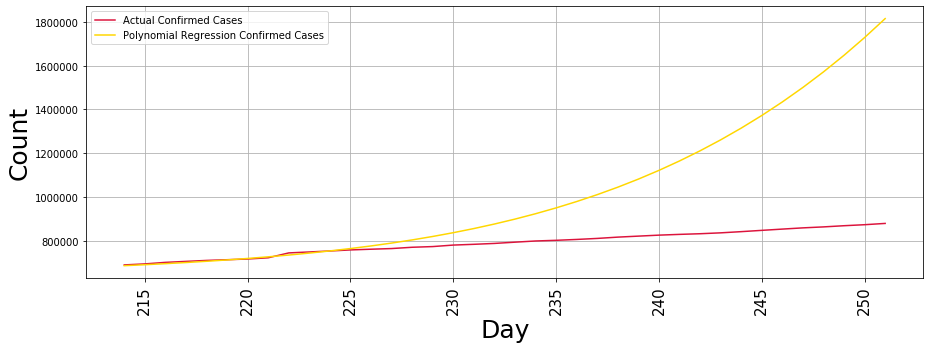

MAE: 225202.62716488854
MSE: 124788587637.56422


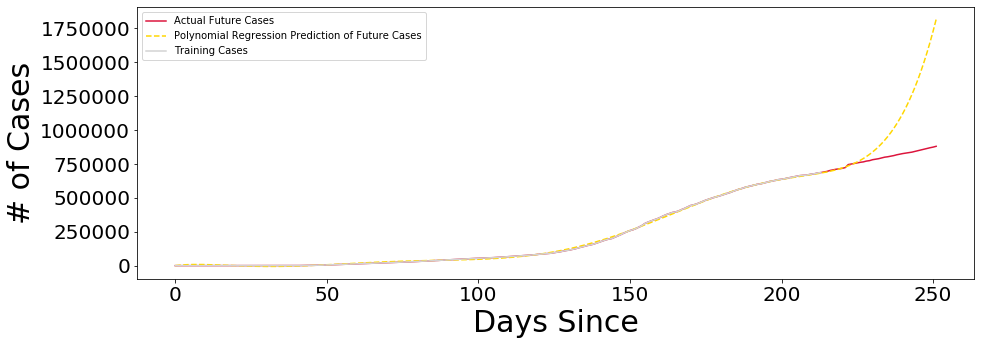

In [193]:
## Using XGBOOST

result=usState.RegressionFeatures('Texas')
# usState.LinearRegression(result[0],result[1])
usState.PolynomialRegression(result[0],result[1])

## Using Artificial Neural Network¶

In [180]:
# usState.PredictionAnn("New York","cases")

In [182]:
# usState.PredictionAnn("New York","cases")

In [183]:
# usState.PredictionAnn("New York","deaths")

## Using XGBOOST

In [186]:
# usState.PredictionXGBOOST("New York","cases")

In [187]:
## Using XGBOOST

result=usState.RegressionFeatures('Texas')
# usState.LinearRegression(result[0],result[1])
usState.PolynomialRegression(resu lt[0],result[1])

In [ ]:
# usState.ARIMAPrediction("New York")

In [87]:
# usState.statelist
# usState.SimpleRegression("New York")
# usState.PredictionSIR(float(13993750) ,"California",'cases')

In [88]:
# usState.fit_logistic("California","cases")

In [115]:
# pols=usState.ARIMS("New York")

# # # pols[2]
# pols[0].plot()
# pd.DataFrame(pols[1],pols[0].index).plot(color='red')
# pols[0].index



2020-10-20 00:00:00
date
2020-03-01         1
2020-03-02         1
2020-03-03         2
2020-03-04        11
2020-03-05        22
               ...  
2020-10-16    485838
2020-10-17    487626
2020-10-18    489016
2020-10-19    490015
2020-10-20    491216
Name: cases, Length: 234, dtype: int64


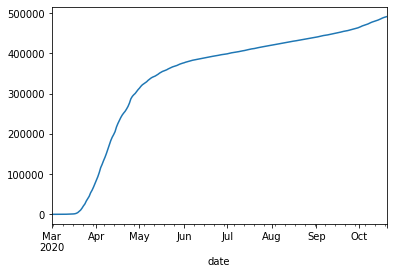

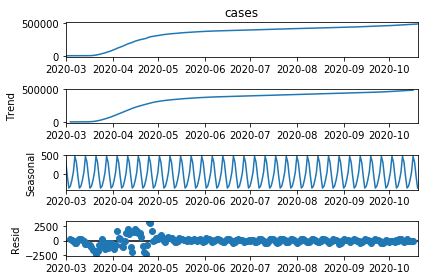

/home/ubuntu/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/home/ubuntu/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/home/ubuntu/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/home/ubuntu/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/home/ubuntu/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/home/ubuntu/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:

/home/ubuntu/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/home/ubuntu/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/home/ubuntu/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/home/ubuntu/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/home/ubuntu/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/home/ubuntu/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:

/home/ubuntu/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/home/ubuntu/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/home/ubuntu/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/home/ubuntu/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/home/ubuntu/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/home/ubuntu/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: Valu

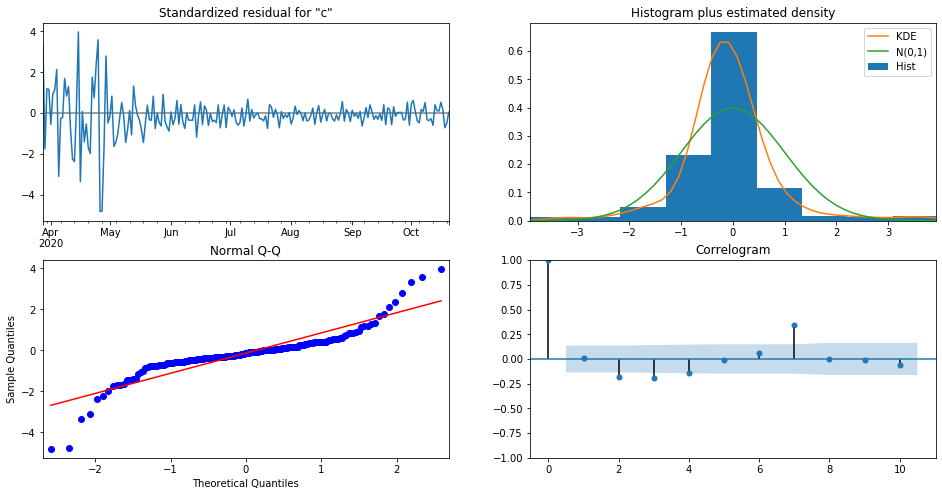

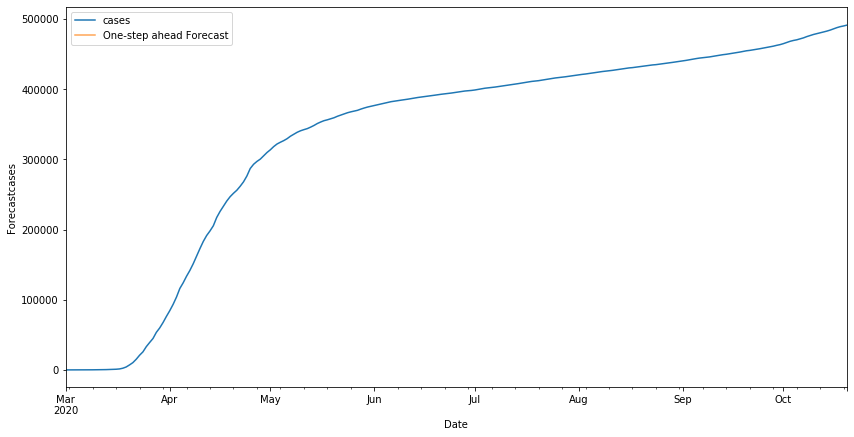

In [114]:
usState.ARIMAPrediction("New York")

X_train ----[[0.00000000e+00]
 [0.00000000e+00]
 [2.30478473e-06]
 [2.30478473e-05]
 [4.84004794e-05]
 [9.91057435e-05]
 [2.02821057e-04]
 [2.42002397e-04]
 [3.24974647e-04]
 [3.96422974e-04]
 [4.97833502e-04]
 [7.49055038e-04]
 [9.68009588e-04]
 [1.40361390e-03]
 [1.68479764e-03]
 [2.18724071e-03]
 [3.16677422e-03]
 [5.49921637e-03]
 [9.58790449e-03]
 [1.63916290e-02]
 [2.39006177e-02]
 [3.50027657e-02]
 [4.81653914e-02]
 [5.92398820e-02]
 [7.63252512e-02]
 [9.00179773e-02]
 [1.03127593e-01]
 [1.23342860e-01]
 [1.37784641e-01]
 [1.55579884e-01]
 [1.75647645e-01]
 [1.94438554e-01]
 [2.15172398e-01]
 [2.38978519e-01]
 [2.67267447e-01]
 [2.85986909e-01]
 [3.07430626e-01]
 [3.26592606e-01]
 [3.48644787e-01]
 [3.73455794e-01]
 [3.98333641e-01]
 [4.21750254e-01]
 [4.41191113e-01]
 [4.56282843e-01]
 [4.73342860e-01]
 [5.00435604e-01]
 [5.20328201e-01]
 [5.37687840e-01]
 [5.54395224e-01]
 [5.68682585e-01]
 [5.79899972e-01]
 [5.89865862e-01]
 [6.02908638e-01]
 [6.17523278e-01]
 [6.36620725e-01

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 1, 50)             10400     
_________________________________________________________________
dropout_5 (Dropout)          (None, 1, 50)             0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 1, 50)             20200     
_________________________________________________________________
dropout_6 (Dropout)          (None, 1, 50)             0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 1, 50)             20200     
_________________________________________________________________
dropout_7 (Dropout)          (None, 1, 50)             0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 1, 30)            

6/6 [==============================] - 0s 11ms/step - loss: 0.0065 - val_loss: 2.7105e-04
Epoch 66/100
6/6 [==============================] - 0s 12ms/step - loss: 0.0094 - val_loss: 3.4423e-04
Epoch 67/100
6/6 [==============================] - 0s 16ms/step - loss: 0.0084 - val_loss: 3.8981e-04
Epoch 68/100
6/6 [==============================] - 0s 14ms/step - loss: 0.0087 - val_loss: 2.4346e-04
Epoch 69/100
6/6 [==============================] - 0s 13ms/step - loss: 0.0063 - val_loss: 4.2176e-04
Epoch 70/100
6/6 [==============================] - 0s 11ms/step - loss: 0.0081 - val_loss: 3.2903e-04
Epoch 71/100
6/6 [==============================] - 0s 11ms/step - loss: 0.0088 - val_loss: 4.4161e-04
Epoch 72/100
6/6 [==============================] - 0s 16ms/step - loss: 0.0074 - val_loss: 4.2561e-04
Epoch 73/100
6/6 [==============================] - 0s 14ms/step - loss: 0.0072 - val_loss: 5.3112e-04
Epoch 74/100
6/6 [==============================] - 0s 12ms/step - loss: 0.0077 - val_

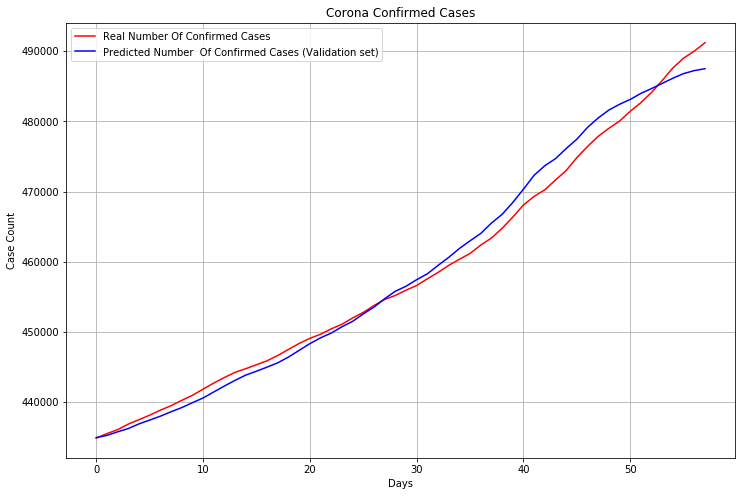

In [28]:
# usState.ProphetPrediction("New York","deaths")
# usState.PredictionwithLSTM(state="New York")

In [20]:
# newYork=usState.ARIMAPrediction("California",start_date='2020-10-10')

In [84]:
# usState.PredictionwithLSTM(state="New York")
# usState.PolynomialRidgeRegression(result[0],result[1])

In [ ]:

# newYork=usState.statedict['New York']
# newYork.plot(x='date',y='cases')
# newYork.plot(x='date',y='deaths')
# newYork.plot(x='date',y='newcases')
# newYork.plot(x='date',y='newdeaths')
# usState.topStatewithCriticalSituation("cases",20)
# usState.GrowthFactor("California","deaths")
# result=usState.RegressionFeatures('Texas')


In [95]:
# Ridge Regression
# usState.RidgeRegression(result[0],result[1])

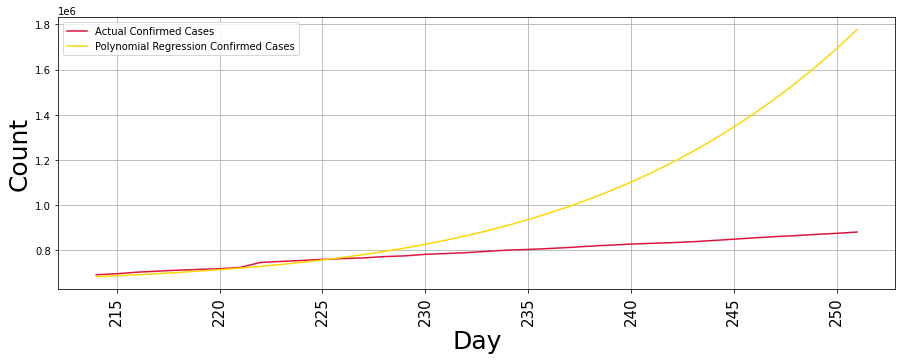

MAE: 212337.18167184215
MSE: 112648537703.33076


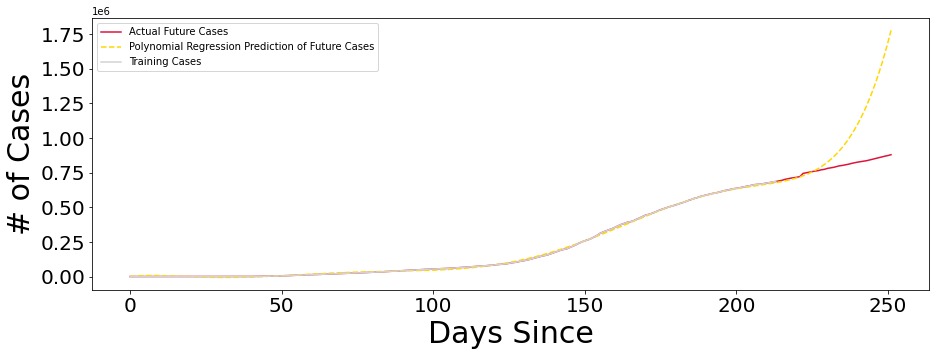

In [90]:
result=usState.RegressionFeatures('Texas')
# usState.LinearRegression(result[0],result[1])
usState.PolynomialRegression(result[0],result[1])

In [56]:
# # Linear Regression
# result=usState.RegressionFeatures('Texas')
# usState.LinearRegression(result[0],result[1])

In [260]:
# result[1]

In [174]:
# usState.PredictionXGBOOST("New York","deaths",period=30)

In [173]:
# usState.PredictionXGBOOST("New York","cases",period=50)

In [102]:
# usState.PredictionAnn("New York","cases")

In [103]:
# usState.PredictionAnn("New York","deaths")

In [162]:
# usState.plot_state("California")

In [153]:
# usState.topStatewithCriticalSituation("deaths",20)

In [6]:
# usState.ProphetPrediction("New York","cases")

# usState.ProphetPrediction("New York","cases")



In [110]:
# 

In [77]:
# usState.statedict["New York"]

In [111]:
# 

In [109]:
# newYork.plot(x='date',y='cases')

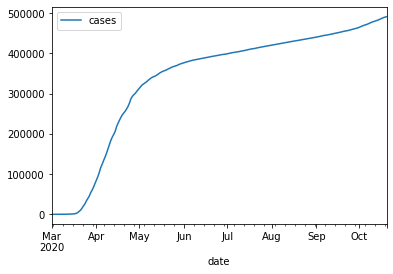